<a href="https://colab.research.google.com/github/hamzajaved240/Battery-modeling-pybamm/blob/main/Many_Particle_Submodels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
!pip install pybamm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 65.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.9/44.9 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 MB 13.5 MB/s eta 0:00:00


In [4]:
import pybamm
import matplotlib.pyplot as plt
model=pybamm.lithium_ion.MPM()
model.variables.search("X-averaged negative particle concentration")

X-averaged negative particle concentration
X-averaged negative particle concentration [mol.m-3]
X-averaged negative particle concentration distribution
X-averaged negative particle concentration distribution [mol.m-3]


In [5]:
c_n=model.variables["X-averaged negative particle concentration distribution"]
c_n.domains

{'primary': ['negative particle'],
 'secondary': ['negative particle size'],
 'tertiary': ['current collector'],
 'quaternary': []}

In [6]:
for var, npts in model.default_var_pts.items():
    print(var,'has', npts,'mesh points')

x_n has 20 mesh points
x_s has 20 mesh points
x_p has 20 mesh points
r_n has 20 mesh points
r_p has 20 mesh points
r_n_prim has 20 mesh points
r_p_prim has 20 mesh points
r_n_sec has 20 mesh points
r_p_sec has 20 mesh points
y has 10 mesh points
z has 10 mesh points
R_n has 30 mesh points
R_p has 30 mesh points


interactive(children=(FloatSlider(value=0.0, description='t', max=3581.9544326866385, step=35.819544326866385)…

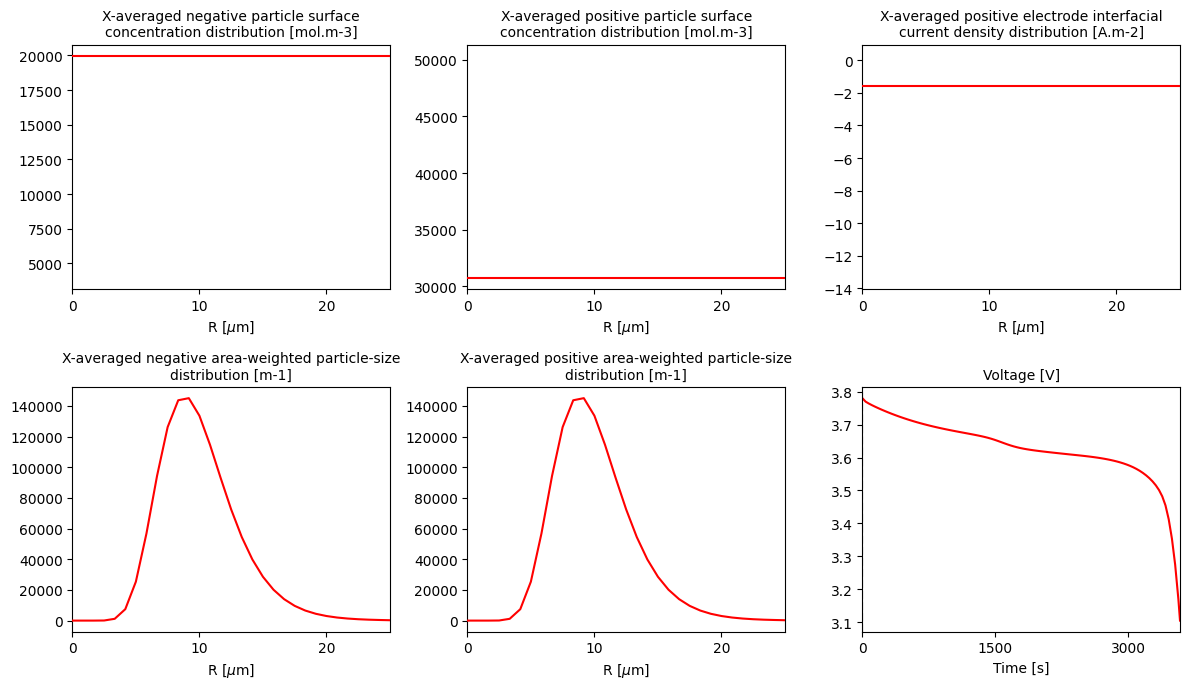

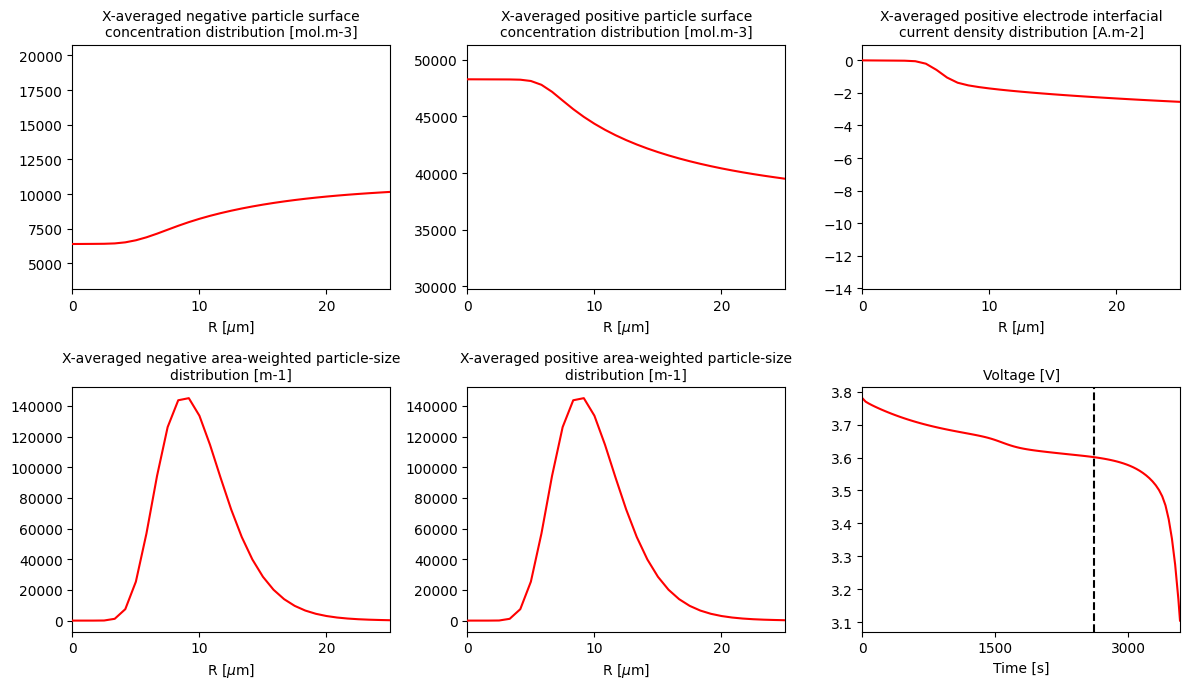

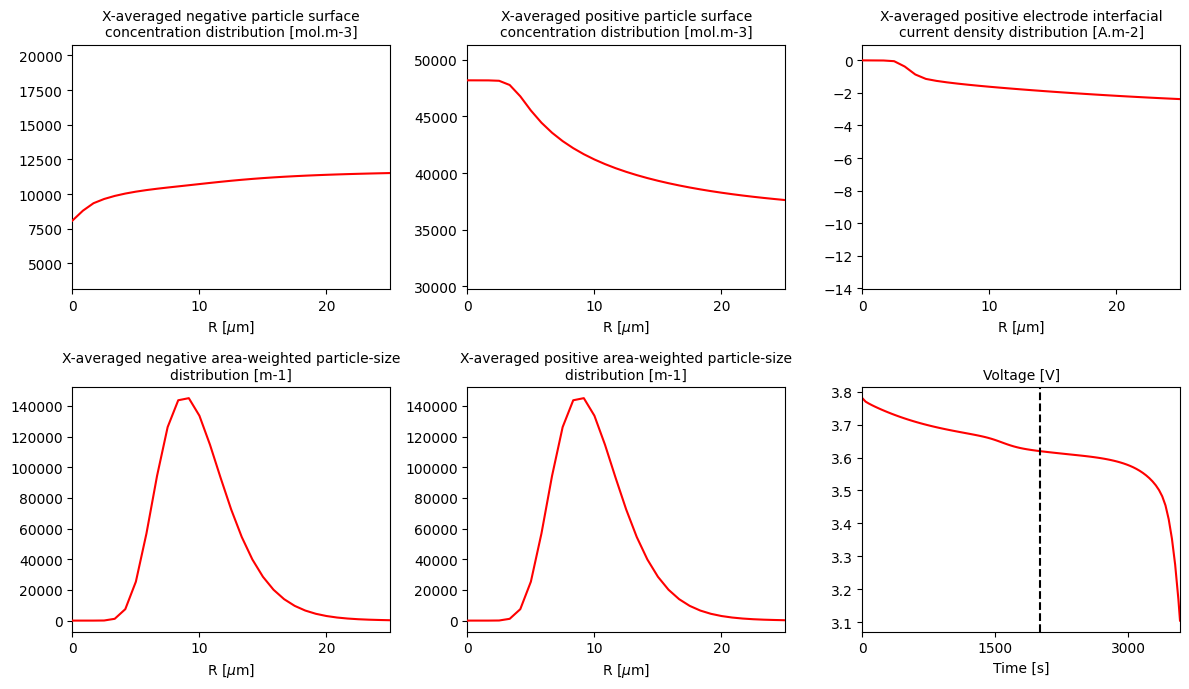

In [14]:
sim = pybamm.Simulation(model)
sim.solve(t_eval=[0, 3600])

# plot some variables that depend on R
output_variables = [
    "X-averaged negative particle surface concentration distribution [mol.m-3]",
    "X-averaged positive particle surface concentration distribution [mol.m-3]",
    "X-averaged positive electrode interfacial current density distribution [A.m-2]",
    "X-averaged negative area-weighted particle-size distribution [m-1]",
    "X-averaged positive area-weighted particle-size distribution [m-1]",
    "Voltage [V]",
]

sim.plot(output_variables=output_variables)

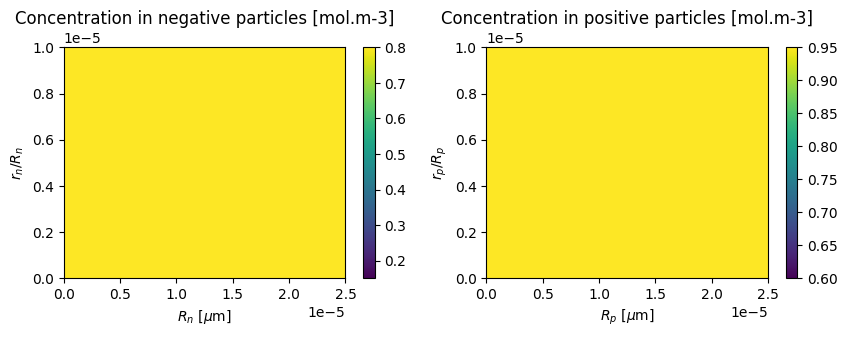

In [15]:
# Concentrations as a function of t, r and R
c_s_n = sim.solution[
    "X-averaged negative particle concentration distribution [mol.m-3]"
]
c_s_p = sim.solution[
    "X-averaged positive particle concentration distribution [mol.m-3]"
]

# r_n, r_p
r_n = sim.solution["r_n [m]"].entries[:, 0, 0]
r_p = sim.solution["r_p [m]"].entries[:, 0, 0]
# dimensional R_n, R_p
R_n = sim.solution["Negative particle sizes [m]"].entries[:, 0]
R_p = sim.solution["Positive particle sizes [m]"].entries[:, 0]
t = sim.solution["Time [s]"].entries


def plot_concentrations(t):
    f, axs = plt.subplots(1, 2, figsize=(10, 3))
    plot_c_n = axs[0].pcolormesh(
        R_n, r_n, c_s_n(r=r_n, R=R_n, t=t), vmin=0.15, vmax=0.8
    )
    plot_c_p = axs[1].pcolormesh(
        R_p, r_p, c_s_p(r=r_p, R=R_p, t=t), vmin=0.6, vmax=0.95
    )
    axs[0].set_xlabel(r"$R_n$ [$\mu$m]")
    axs[1].set_xlabel(r"$R_p$ [$\mu$m]")
    axs[0].set_ylabel(r"$r_n / R_n$")
    axs[1].set_ylabel(r"$r_p / R_p$")
    axs[0].set_title("Concentration in negative particles [mol.m-3]")
    axs[1].set_title("Concentration in positive particles [mol.m-3]")
    plt.colorbar(plot_c_n, ax=axs[0])
    plt.colorbar(plot_c_p, ax=axs[1])

    plt.show()


# initial time
plot_concentrations(t[0])

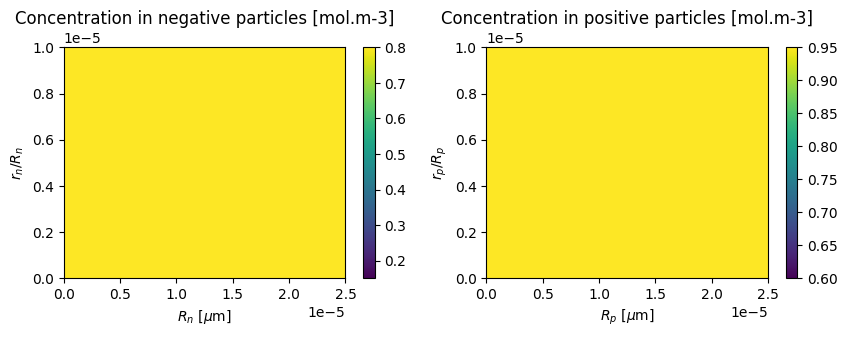

In [16]:
# final time
plot_concentrations(t[-1])

In [17]:
# Parameter set (no distribution parameters by default)
params = pybamm.ParameterValues("Marquis2019")

# Extract the radii values. We will choose these to be the means of our area-weighted distributions
R_a_n_dim = params["Negative particle radius [m]"]
R_a_p_dim = params["Positive particle radius [m]"]

# Standard deviations (dimensional)
sd_a_n_dim = 0.2 * R_a_n_dim
sd_a_p_dim = 0.6 * R_a_p_dim

# Minimum and maximum particle sizes (dimensional)
R_min_n = 0
R_min_p = 0
R_max_n = 2 * R_a_n_dim
R_max_p = 3 * R_a_p_dim

# Set the area-weighted particle-size distributions.
# Choose a lognormal (but any pybamm function could be used)


def f_a_dist_n_dim(R):
    return pybamm.lognormal(R, R_a_n_dim, sd_a_n_dim)


def f_a_dist_p_dim(R):
    return pybamm.lognormal(R, R_a_p_dim, sd_a_p_dim)


# Note: the only argument must be the particle size R

interactive(children=(FloatSlider(value=0.0, description='t', max=3511.9448283395686, step=35.119448283395684)…

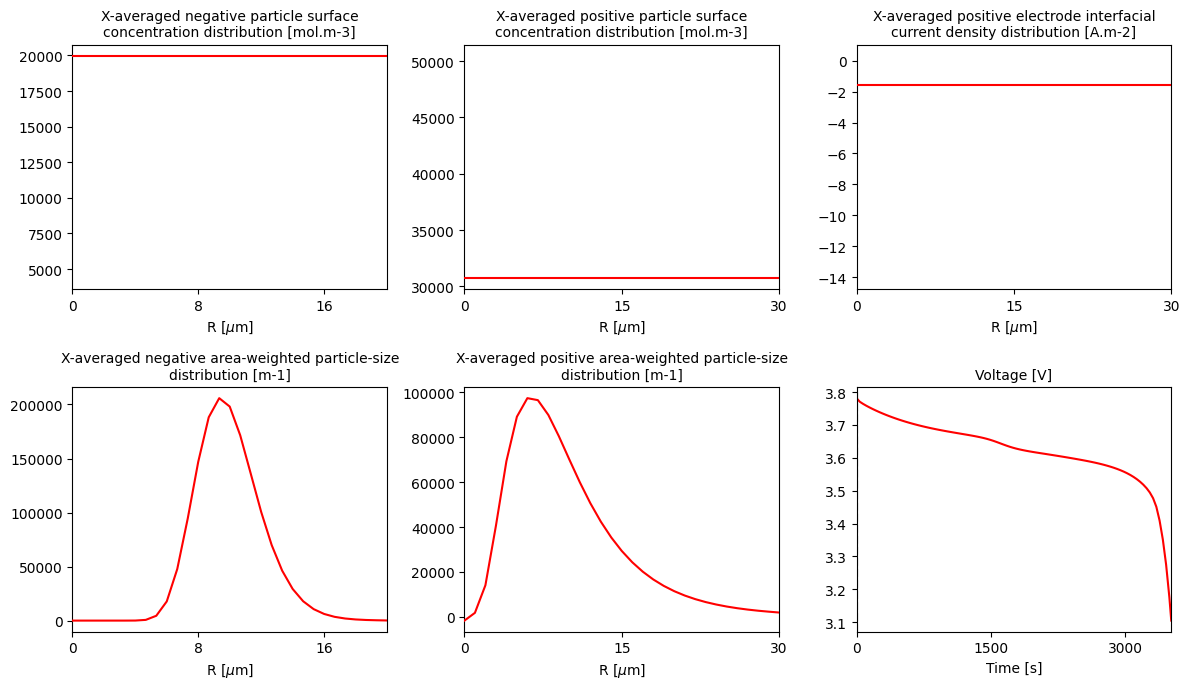

In [18]:
# input distribution params to the dictionary
distribution_params = {
    "Negative minimum particle radius [m]": R_min_n,
    "Positive minimum particle radius [m]": R_min_p,
    "Negative maximum particle radius [m]": R_max_n,
    "Positive maximum particle radius [m]": R_max_p,
    "Negative area-weighted " + "particle-size distribution [m-1]": f_a_dist_n_dim,
    "Positive area-weighted " + "particle-size distribution [m-1]": f_a_dist_p_dim,
}
params.update(distribution_params, check_already_exists=False)
sim = pybamm.Simulation(model, parameter_values=params)
sim.solve(t_eval=[0, 3600])

sim.plot(output_variables=output_variables)


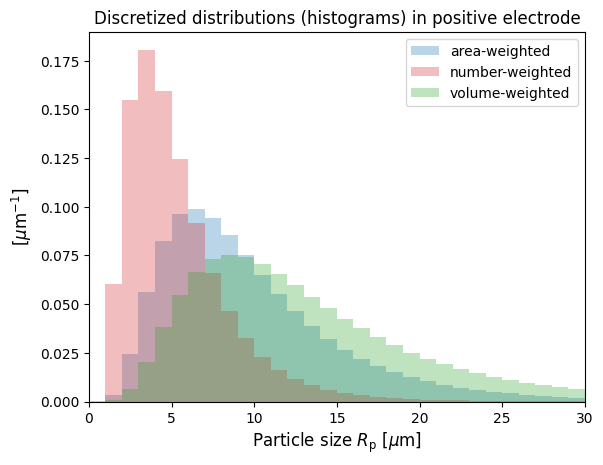

In [19]:
# The discrete sizes or "bins" used, and the distributions
R_p = sim.solution["Positive particle sizes [m]"].entries[
    :, 0
]  # const in the current collector direction
# The distributions
f_a_p = sim.solution[
    "X-averaged positive area-weighted particle-size distribution [m-1]"
].entries[:, 0]
f_num_p = sim.solution[
    "X-averaged positive number-based particle-size distribution [m-1]"
].entries[:, 0]
f_v_p = sim.solution[
    "X-averaged positive volume-weighted particle-size distribution [m-1]"
].entries[:, 0]


# plot
width_p = (R_p[-1] - R_p[-2]) / 1e-6
plt.bar(
    R_p / 1e-6,
    f_a_p * 1e-6,
    width=width_p,
    alpha=0.3,
    color="tab:blue",
    label="area-weighted",
)
plt.bar(
    R_p / 1e-6,
    f_num_p * 1e-6,
    width=width_p,
    alpha=0.3,
    color="tab:red",
    label="number-weighted",
)
plt.bar(
    R_p / 1e-6,
    f_v_p * 1e-6,
    width=width_p,
    alpha=0.3,
    color="tab:green",
    label="volume-weighted",
)
plt.xlim((0, 30))
plt.xlabel("Particle size $R_{\mathrm{p}}$ [$\mu$m]", fontsize=12)
plt.ylabel("[$\mu$m$^{-1}$]", fontsize=12)
plt.legend(fontsize=10)
plt.title("Discretized distributions (histograms) in positive electrode")
plt.show()

In [20]:
# Define standard deviation in negative electrode to vary
sd_a_p_dim = pybamm.Parameter(
    "Positive electrode area-weighted particle-size standard deviation [m]"
)

# Set the area-weighted particle-size distribution


def f_a_dist_p_dim(R):
    return pybamm.lognormal(R, R_a_p_dim, sd_a_p_dim)


# input to param dictionary
distribution_params = {
    "Positive electrode area-weighted particle-size "
    + "standard deviation [m]": "[input]",
    "Positive area-weighted " + "particle-size distribution [m-1]": f_a_dist_p_dim,
}
params.update(distribution_params, check_already_exists=False)

interactive(children=(FloatSlider(value=0.0, description='t', max=1.9444444444444444, step=0.01944444444444444…

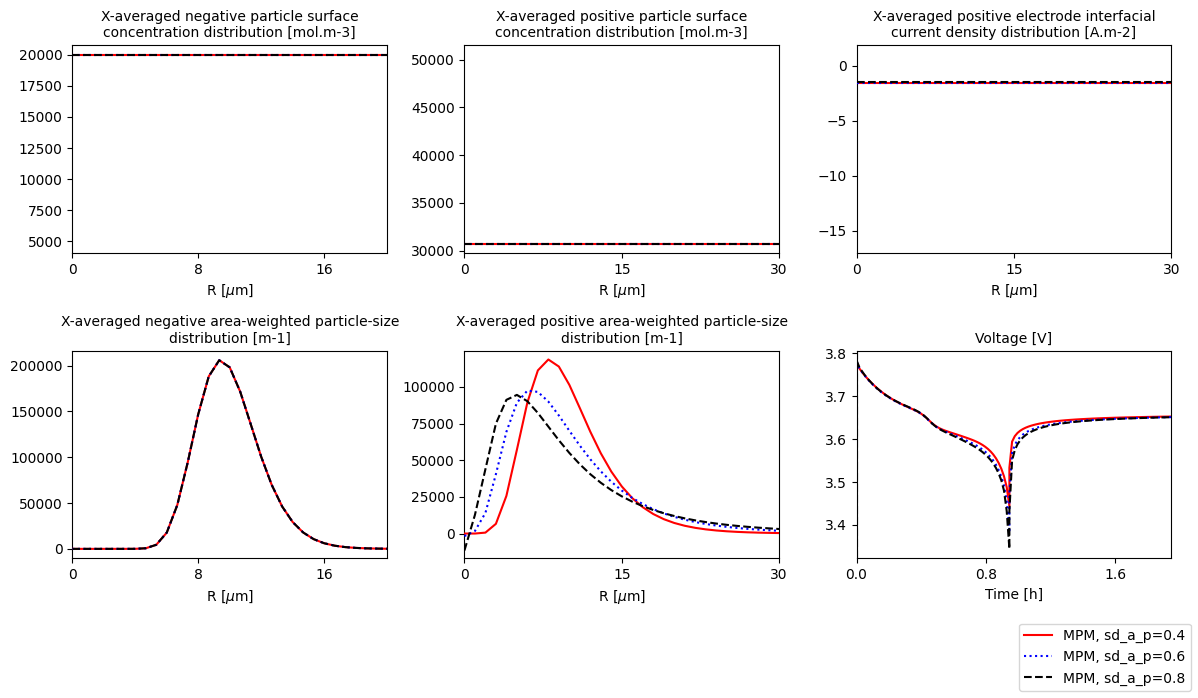

In [21]:
# Experiment with a relaxation period, to see the effect of distribution width
experiment = pybamm.Experiment(["Discharge at 1 C for 3400 s", "Rest for 1 hours"])

sim = pybamm.Simulation(model, parameter_values=params, experiment=experiment)
solutions = []
for sd_a_p in [0.4, 0.6, 0.8]:
    solution = sim.solve(
        inputs={
            "Positive electrode area-weighted particle-size "
            + "standard deviation [m]": sd_a_p * R_a_p_dim
        }
    )
    solutions.append(solution)


pybamm.dynamic_plot(
    solutions,
    output_variables=output_variables,
    labels=["MPM, sd_a_p=0.4", "MPM, sd_a_p=0.6", "MPM, sd_a_p=0.8"],
)

In [22]:
print("The mean of the input lognormal was:", R_a_p_dim)
print("The means of discretized distributions are:")
for solution in solutions:
    R = solution["Positive area-weighted mean particle radius [m]"]
    print("Positive area-weighted mean particle radius [m]", R.entries[0])

The mean of the input lognormal was: 1e-05
The means of discretized distributions are:
Positive area-weighted mean particle radius [m] 9.972515783613797e-06
Positive area-weighted mean particle radius [m] 9.673853099212893e-06
Positive area-weighted mean particle radius [m] 9.124186918191047e-06


In [23]:
print("The standard deviations of the input lognormal were:")
print(0.4 * R_a_p_dim)
print(0.6 * R_a_p_dim)
print(0.8 * R_a_p_dim)
print("The standard deviations of discretized distributions are:")
for solution in solutions:
    sd = solution["Positive area-weighted particle-size standard deviation [m]"]
    print("Positive area-weighted particle-size standard deviation [m]", sd.entries[0])

The standard deviations of the input lognormal were:
4.000000000000001e-06
6e-06
8.000000000000001e-06
The standard deviations of discretized distributions are:
Positive area-weighted particle-size standard deviation [m] 3.918218937679726e-06
Positive area-weighted particle-size standard deviation [m] 5.180362201055077e-06
Positive area-weighted particle-size standard deviation [m] 5.815728559306214e-06


interactive(children=(FloatSlider(value=0.0, description='t', max=3500.0, step=35.0), Output()), _dom_classes=…

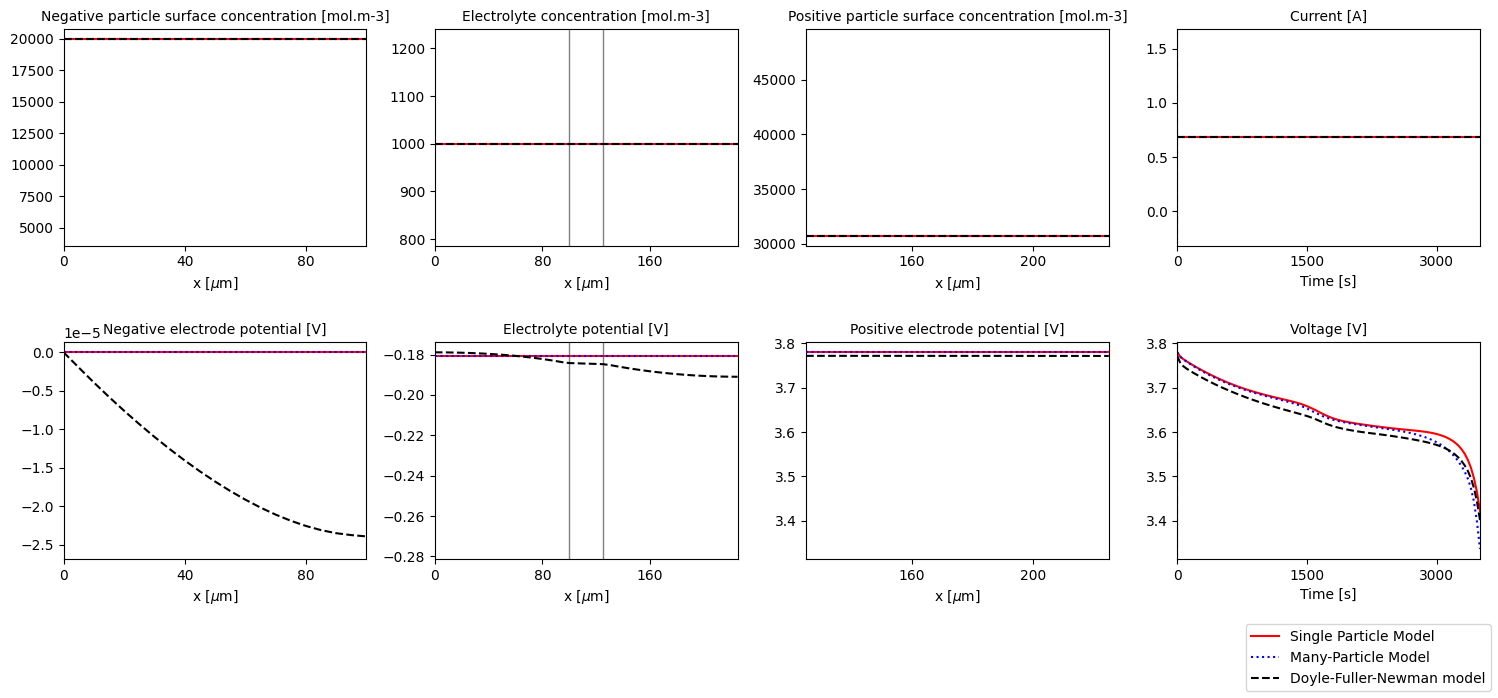

In [24]:
models = [pybamm.lithium_ion.SPM(), pybamm.lithium_ion.MPM(), pybamm.lithium_ion.DFN()]

# solve
sims = []
for model in models:
    sim = pybamm.Simulation(model)
    sim.solve(t_eval=[0, 3500])
    sims.append(sim)

# plot
pybamm.dynamic_plot(sims)

interactive(children=(FloatSlider(value=0.0, description='t', max=3500.0, step=35.0), Output()), _dom_classes=…

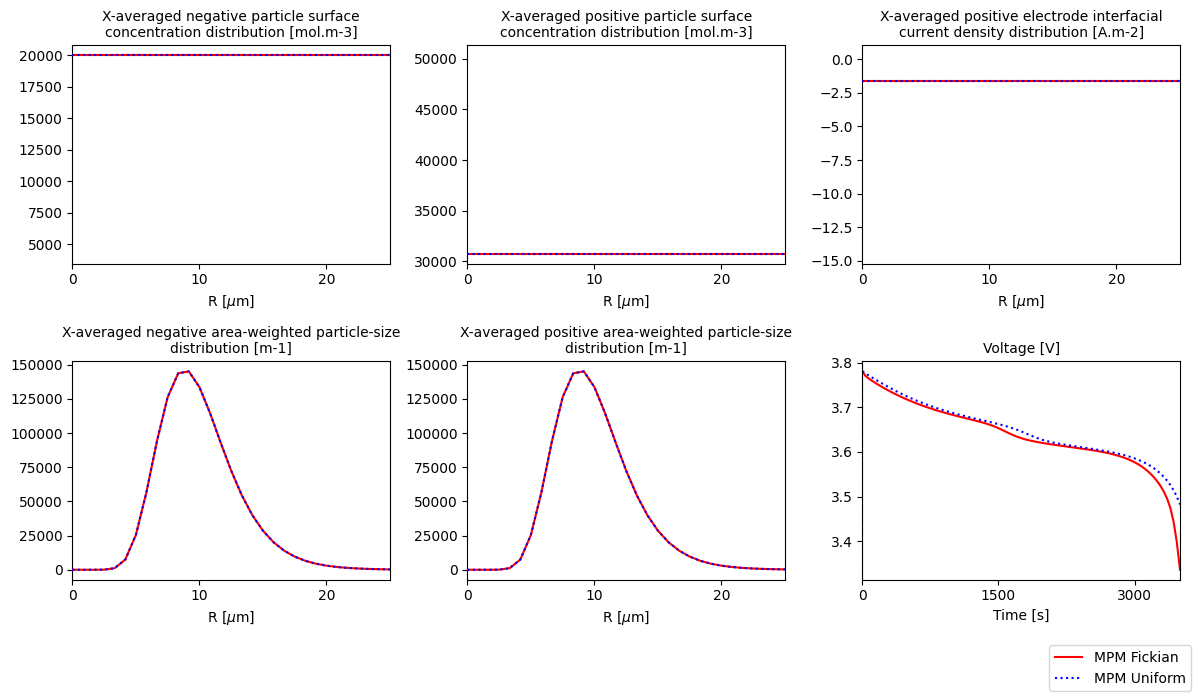

In [25]:
model_Fickian = pybamm.lithium_ion.MPM(name="MPM Fickian")
model_Uniform = pybamm.lithium_ion.MPM(
    name="MPM Uniform", options={"particle": "uniform profile"}
)

sim_Fickian = pybamm.Simulation(model_Fickian)
sim_Uniform = pybamm.Simulation(model_Uniform)

sim_Fickian.solve(t_eval=[0, 3500])
sim_Uniform.solve(t_eval=[0, 3500])

pybamm.dynamic_plot([sim_Fickian, sim_Uniform], output_variables=output_variables)

interactive(children=(FloatSlider(value=0.0, description='t', max=1.0, step=0.01), Output()), _dom_classes=('w…

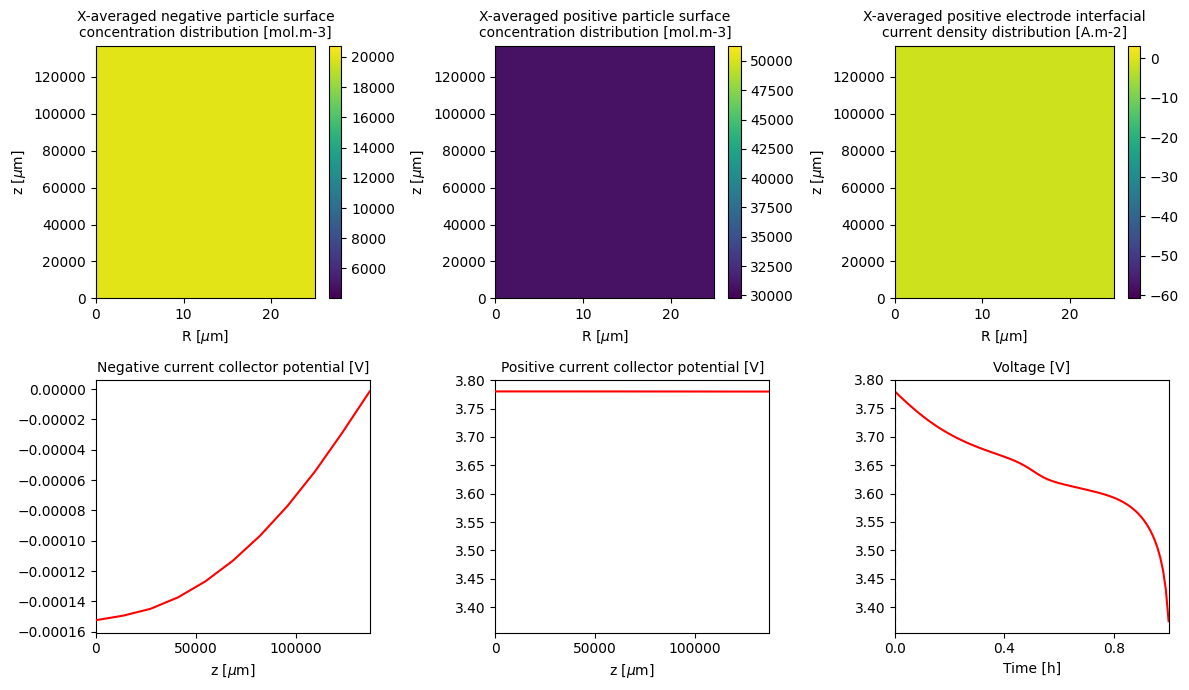

In [26]:
# choose model options
model_cc = pybamm.lithium_ion.MPM(
    options={
        "current collector": "potential pair",
        "dimensionality": 1,
        "particle": "uniform profile",  # to reduce computation time
    }
)

# solve
sim_cc = pybamm.Simulation(model_cc)
sim_cc.solve(t_eval=[0, 3600])

# variables to plot
output_variables = [
    "X-averaged negative particle surface concentration distribution [mol.m-3]",
    "X-averaged positive particle surface concentration distribution [mol.m-3]",
    "X-averaged positive electrode interfacial current density distribution [A.m-2]",
    "Negative current collector potential [V]",
    "Positive current collector potential [V]",
    "Voltage [V]",
]
pybamm.dynamic_plot(sim_cc, output_variables=output_variables)